# Running mokapot

Change output df to "pin" format
<br>[fibertools/fiberdata.py make_percolator_input](https://github.com/fiberseq/fibertools/blob/5fafd4301ef28a17027d2c4d5b6ef61b950fd3f9/fibertools/fiberdata.py#L129-L170)

* give a fake peptide column name
* add an ID column peptide (of unique IDs)
* col 1. Label
    * label in the 1st position
    * give things within ChIP-seq peaks = 1 (positive data)
    * not within a ChIP-seq peak = -1 (negative data)
    * I will have no 0 values
* SpecId
    * set index of df (0 - now)
    * copy to cols: peptide, proteins, scanner
    * do NOT need log_msp_len

* don't need train pin subsetting `train = mokapot.read_pin(pin_df`
* train_psms `psms = peptide spectrum match, used in proteomics`
* scale_pos_weight (hyper parameter for XGBoost on how to weigh positive vs negative labels based on frequency in the data)
* grid
    * n_estimators: how many decision trees to use (~100 is normal)
    * scale_pos_weight: weighing for imbalanced data
    * max_depth: depth of tree
    * min_child_weight: min # of rows needed to touch a terminal leaf for a leaf to be retained
    * gamma: learning rate, gradient descent algorithm, slow = risk of overfitting, fast: generalizes to new data better

In [1]:
import os
import pandas as pd
import numpy as np

fibertools installed without dependencies

In [12]:
import mokapot
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

In [16]:
import logging

In [3]:
# set folders
project_dir = "/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting"
data_dir = "{}/feature_data".format(project_dir)
output_dir = "{}/mokapot_res".format(project_dir)

## convert feature table to pin format

### make_percolator_input

need to add the following columns: [SpecID, Label, Peptide, Proteins]

#### format positive data

In [245]:
# CTCF L (best footprint according to Andrew)
data_type = "positive"
motif_type = "L"
data_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.txt".format(data_dir, data_type, motif_type)

In [247]:
label_val = 1 if "positive" in data_file else -1

In [251]:
data_file.split(".")[0] + ".pin"

'/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_positive_m6a_fiberseq_L_100bp_features.pin'

In [186]:
%%time

# read in feature df
n_rows = None
df = pd.read_csv(data_file, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df.shape[0], df.shape[1]))

rows: 238,348 | cols: 128
CPU times: user 1.58 s, sys: 139 ms, total: 1.72 s
Wall time: 1.73 s


In [187]:
df.head()

,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
0,chr10_100338605_+,m54329U_210323_190418/12585455/ccs,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333
1,chr10_100338605_+,m54329U_210323_190418/16515087/ccs,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
2,chr10_100338605_+,m54329U_210323_190418/169477611/ccs,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000
3,chr10_100338605_+,m54329U_210323_190418/173999297/ccs,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
4,chr10_100338605_+,m54329U_210323_190418/180160021/ccs,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333


In [188]:
d = df.copy(deep=True)

# add Label col of 0's
d.insert(1, "Label", 0)

# make Label value 1 for positive data
d["Label"] = d["Label"].replace(0, 1)
print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 238,348 | cols: 129


In [189]:
# add and drop columns needed for mokapot

# remove non-feature columns
to_remove = ["motif_name", "query_name"]
d.drop(to_remove, axis=1, inplace=True)

# create SpecID col with unique ID's (set to index for now)
d.insert(0, "SpecID", d.index)
d["Peptide"] = d.SpecID
d["Proteins"] = d.SpecID
d["scannr"] = d.SpecID

print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 238,348 | cols: 131


In [190]:
d.head()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,1,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0,0,0
1,1,1,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,1,1,1
2,2,1,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,2,2,2
3,3,1,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,3,3,3
4,4,1,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,4,4,4


#### save features to pin file

In [191]:
data_type = "positive"

In [192]:
# Percolator tab-delimited format
pin_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, data_type, motif_type)
d.to_csv(pin_file, sep="\t", header=True, index=False)
print("Saved pin file to: {}".format(pin_file))

Saved pin file to: /mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_positive_m6a_fiberseq_L_100bp_features.pin


### format negative data

In [193]:
# negative CTCF L
data_type = "negative"
motif_type = "L"
data_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_small_features.txt".format(data_dir, data_type, motif_type)

In [194]:
%%time

# read in feature df
n_rows = None
df = pd.read_csv(data_file, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df.shape[0], df.shape[1]))

rows: 65,943 | cols: 128
CPU times: user 476 ms, sys: 23.9 ms, total: 500 ms
Wall time: 504 ms


In [34]:
df.head()

,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
0,chr10_100001134_+,m54329U_210326_192251/136053044/ccs,154.0,6.0,0.0,1.0,16.0,14.0,16.0,0.400,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.000000
1,chr10_100009901_+,m54329U_210813_020940/108857329/ccs,268.0,6.0,6.0,4.0,9.0,10.0,7.0,0.225,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,chr10_100076460_+,m64076_210328_012155/112330052/ccs,69.0,1.0,10.0,8.0,22.0,22.0,15.0,0.550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,chr10_100085646_-,m54329U_210810_004956/12124794/ccs,55.0,2.0,3.0,5.0,22.0,23.0,15.0,0.550,...,0.0,0.0,1.0,0.0,1.0,0.5,1.0,0.5,1.0,0.333333
4,chr10_100118172_-,m64076_221119_202646/24772945/ccs,71.0,2.0,6.0,3.0,30.0,25.0,16.0,0.750,...,1.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000


In [195]:
d = df.copy(deep=True)

# add Label col of 0's for negative data
d.insert(1, "Label", -1)

print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 65,943 | cols: 129


In [196]:
# add and drop columns needed for mokapot

# remove non-feature columns
to_remove = ["motif_name", "query_name"]
d.drop(to_remove, axis=1, inplace=True)

# create SpecID col with unique ID's (set to index for now)
d.insert(0, "SpecID", d.index)
d["Peptide"] = d.SpecID
d["Proteins"] = d.SpecID
d["scannr"] = d.SpecID

print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 65,943 | cols: 131


In [197]:
d.head()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,-1,154.0,6.0,0.0,1.0,16.0,14.0,16.0,0.400,...,0.0,0.0,0.0,2.0,0.0,0.0,0.000000,0,0,0
1,1,-1,268.0,6.0,6.0,4.0,9.0,10.0,7.0,0.225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1,1,1
2,2,-1,69.0,1.0,10.0,8.0,22.0,22.0,15.0,0.550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2,2,2
3,3,-1,55.0,2.0,3.0,5.0,22.0,23.0,15.0,0.550,...,0.0,1.0,0.5,1.0,0.5,1.0,0.333333,3,3,3
4,4,-1,71.0,2.0,6.0,3.0,30.0,25.0,16.0,0.750,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,4,4,4


#### save features to pin

In [198]:
# Percolator tab-delimited format
pin_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, data_type, motif_type)
d.to_csv(pin_file, sep="\t", header=True, index=False)
print("Saved pin file to: {}".format(pin_file))

Saved pin file to: /mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_negative_m6a_fiberseq_L_100bp_features.pin


### merge positive and negative data

In [199]:
# make sample data
positive_pin = "{}/CTCF_positive_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)
negative_pin = "{}/CTCF_negative_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)

In [200]:
# read in positive pin
n_rows = None
df_pos = pd.read_csv(positive_pin, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

rows: 238,348 | cols: 131


In [201]:
# read in negative pin
df_neg = pd.read_csv(negative_pin, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

rows: 65,943 | cols: 131


In [202]:
# merge positive and negative test data
d = pd.concat([df_pos, df_neg], axis=0)

# reindex
d = d.reset_index(drop=True)

# reindex SpecID col & copy to Peptide, Proteins, and scannr columns
d["SpecID"] = d.index
d["Peptide"] = d.SpecID
d["Proteins"] = d.SpecID
d["scannr"] = d.SpecID

print("Test merged - rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

Test merged - rows: 304,291 | cols: 131


In [204]:
print("Positive - rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))
print("Negative - rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))
print("Merged - rows {:,}".format(df_pos.shape[0] + df_neg.shape[0]))

Positive - rows: 238,348 | cols: 131
Negative - rows: 65,943 | cols: 131
Merged - rows 304,291


In [205]:
d.head()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,1,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0,0,0
1,1,1,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,1,1,1
2,2,1,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,2,2,2
3,3,1,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,3,3,3
4,4,1,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,4,4,4


In [206]:
d.tail()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
304286,304286,-1,247.0,4.0,12.0,2.0,19.0,21.0,19.0,0.475,...,0.0,1.0,0.0,1.0,1.0,2.0,0.000000,304286,304286,304286
304287,304287,-1,303.0,17.0,2.0,8.0,20.0,23.0,17.0,0.500,...,0.0,1.0,0.0,1.0,0.5,2.0,0.000000,304287,304287,304287
304288,304288,-1,159.0,16.0,15.0,17.0,17.0,24.0,19.0,0.425,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,304288,304288,304288
304289,304289,-1,51.0,3.0,1.0,5.0,20.0,18.0,17.0,0.500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,304289,304289,304289
304290,304290,-1,59.0,1.0,3.0,3.0,19.0,21.0,17.0,0.475,...,0.0,1.0,0.0,2.0,0.0,1.0,0.333333,304290,304290,304290


### save merged features to pin

In [207]:
# Percolator tab-delimited format
pin_file = "{}/CTCF_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)
d.to_csv(pin_file, sep="\t", header=True, index=False)
print("Saved pin file to: {}".format(pin_file))

Saved pin file to: /mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features.pin


## Analyze features

### make __test data__

In [154]:
# make sample data
positive_pin = "{}/CTCF_positive_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)
negative_pin = "{}/CTCF_negative_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type)

In [155]:
# read in positive pin
#n_rows = 100000
#df_pos = pd.read_csv(positive_pin, sep="\t", nrows=n_rows)
#print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

rows: 100,000 | cols: 131


In [156]:
# read in negative pin
df_neg = pd.read_csv(negative_pin, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

rows: 65,943 | cols: 131


In [157]:
# merge positive and negative test data
d_t = pd.concat([df_pos, df_neg], axis=0)

# reindex
d_t = d_t.reset_index(drop=True)

# reindex SpecID col & copy to Peptide, Proteins, and scannr columns
d_t["SpecID"] = d_t.index
d_t["Peptide"] = d_t.SpecID
d_t["Proteins"] = d_t.SpecID
d_t["scannr"] = d_t.SpecID

print("Test merged - rows: {:,} | cols: {:,}".format(d_t.shape[0], d_t.shape[1]))

Test merged - rows: 165,943 | cols: 131


In [158]:
# merge positive and negative test data
d_t = pd.concat([df_pos, df_neg], axis=0)

# reindex
d_t = d_t.reset_index(drop=True)

# reindex SpecID col & copy to Peptide, Proteins, and scannr columns
d_t["SpecID"] = d_t.index
d_t["Peptide"] = d_t.SpecID
d_t["Proteins"] = d_t.SpecID
d_t["scannr"] = d_t.SpecID

print("Test merged - rows: {:,} | cols: {:,}".format(d_t.shape[0], d_t.shape[1]))

Test merged - rows: 165,943 | cols: 131


In [159]:
d_t

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,1,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.450,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0,0,0
1,1,1,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.450,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,1,1,1
2,2,1,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.450,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,2,2,2
3,3,1,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.450,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,3,3,3
4,4,1,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.450,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165938,165938,0,247.0,4.0,12.0,2.0,19.0,21.0,19.0,0.475,...,0.000000,1.0,0.0,1.0,1.0,2.0,0.000000,165938,165938,165938
165939,165939,0,303.0,17.0,2.0,8.0,20.0,23.0,17.0,0.500,...,0.000000,1.0,0.0,1.0,0.5,2.0,0.000000,165939,165939,165939
165940,165940,0,159.0,16.0,15.0,17.0,17.0,24.0,19.0,0.425,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,165940,165940,165940
165941,165941,0,51.0,3.0,1.0,5.0,20.0,18.0,17.0,0.500,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,165941,165941,165941


In [161]:
# save test data
pin_file = "{}/CTCF_m6a_fiberseq_{}_100bp_features-test_{}.pin".format(data_dir, motif_type, n_rows)
d_t.to_csv(pin_file, sep="\t", header=True, index=False)
print("Saved pin file to: {}".format(pin_file))

Saved pin file to: /mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features-test_100000.pin


### make_accessibility_model

In [17]:
# enable nicely formated messages about mokapot's progress
log = True
if log:
    logging.basicConfig(
        level = logging.INFO,
        format = "%(levelname)s: %(message)s"
    )

# run merged data

In [4]:
# get merged data
pin_file = "{}/CTCF_m6a_fiberseq_merged_100bp_features-small_5_noNaN_balanced.pin".format(data_dir)

In [5]:
# read pin file
pin = pd.read_csv(pin_file, sep="\t")

In [6]:
print("Pin - rows: {:,} | cols: {:,}".format(pin.shape[0], pin.shape[1]))
pin.head()

Pin - rows: 1,628,548 | cols: 131


,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,chr10_100046241_-/m54329U_210323_190418/105513...,1,174.0,13.0,10.0,0.0,21.0,16.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0
1,chr10_100046241_-/m54329U_210323_190418/107414...,1,196.0,14.0,14.0,2.0,21.0,16.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1
2,chr10_100046241_-/m54329U_210323_190418/117571...,1,155.0,15.0,9.0,2.0,21.0,17.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,2,2
3,chr10_100046241_-/m54329U_210323_190418/135595...,1,161.0,15.0,13.0,3.0,21.0,17.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,3
4,chr10_100046241_-/m54329U_210323_190418/152242...,1,98.0,11.0,14.0,10.0,21.0,17.0,11.0,0.525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,4,4


In [31]:
# input pin file
pin_file = "{}/CTCF_m6a_fiberseq_merged_100bp_features-small_5_noNaN_balanced.pin".format(data_dir)
assert os.path.exists(pin_file), f"ERROR: file not found: {pin_file}"

# read pin
pin = pd.read_csv(pin_file, sep="\t")
print("Pin features - rows: {:,} | cols: {:,}".format(pin.shape[0], pin.shape[1]))
print("Positive instances: {:,} | negative: {:,}".format(
    pin.Label.value_counts()[1], pin.Label.value_counts()[-1]))

Pin features - rows: 1,628,548 | cols: 131
Positive instances: 814,274 | negative: 814,274


In [32]:
print("Making accessibility model.")
print("dataset size: {:,}".format(pin.shape[0]))

train = pin
# PSM (peptide-spectrum matches, proteomics thing)
train_psms = mokapot.read_pin(train)
print("Train - rows: {:,} | columns: {:,}".format(train.shape[0], train.shape[1]))
# weighing for imbalanced data
scale_pos_weight = sum(train.Label == -1) / sum(train.Label == 1)

# hyper paramaters for XGBoost
grid = {
    # decision trees in model
    "n_estimators": [25, 50, 100],
    "scale_pos_weight": [scale_pos_weight],
    # depth of tree
    "max_depth": [3, 6, 9],
    # rows a terminal leaf need to touch to be kept
    "min_child_weight": [3, 6, 9],
    # learning rate
    "gamma": [0.1, 1, 10],
}

# set up model (ensemble classifier)
xgb_mod = GridSearchCV(
    XGBClassifier(eval_metric = "auc"),
    param_grid = grid,
    cv = 3,
    # receiver operator curve
    scoring = "roc_auc",
    verbose = 2,
)

Making accessibility model.
dataset size: 1,628,548
Train - rows: 1,628,548 | columns: 131


In [33]:
%%time
print("Running mokapot.")
train_fdr = 0.10
test_fdr = 0.05
subset_max_train = 2_000_000

# machine learning model to re-score PSMs
mod = mokapot.Model(xgb_mod, train_fdr=train_fdr, subset_max_train=subset_max_train)
# run mokapot
moka_conf, models = mokapot.brew(psms=train_psms, model=mod, test_fdr=test_fdr)

Running mokapot.


RuntimeError: No PSMs found below the 'eval_fdr'.

### retest with CTCF L dataset

In [34]:
# input pin file
pin_file = "{}/CTCF_m6a_fiberseq_L_100bp_features.pin".format(data_dir)
assert os.path.exists(pin_file), f"ERROR: file not found: {pin_file}"

# read pin
pin = pd.read_csv(pin_file, sep="\t")
print("Pin features - rows: {:,} | cols: {:,}".format(pin.shape[0], pin.shape[1]))
print("Positive instances: {:,} | negative: {:,}".format(
    pin.Label.value_counts()[1], pin.Label.value_counts()[-1]))

Pin features - rows: 304,291 | cols: 131
Positive instances: 238,348 | negative: 65,943


In [35]:
print("Making accessibility model.")
print("dataset size: {:,}".format(pin.shape[0]))

train = pin
# PSM (peptide-spectrum matches, proteomics thing)
train_psms = mokapot.read_pin(train)
print("Train - rows: {:,} | columns: {:,}".format(train.shape[0], train.shape[1]))
# weighing for imbalanced data
scale_pos_weight = sum(train.Label == -1) / sum(train.Label == 1)

# hyper paramaters for XGBoost
grid = {
    # decision trees in model
    "n_estimators": [25, 50, 100],
    "scale_pos_weight": [scale_pos_weight],
    # depth of tree
    "max_depth": [3, 6, 9],
    # rows a terminal leaf need to touch to be kept
    "min_child_weight": [3, 6, 9],
    # learning rate
    "gamma": [0.1, 1, 10],
}

# set up model (ensemble classifier)
xgb_mod = GridSearchCV(
    XGBClassifier(eval_metric = "auc"),
    param_grid = grid,
    cv = 3,
    # receiver operator curve
    scoring = "roc_auc",
    verbose = 2,
)

Making accessibility model.
dataset size: 304,291
Train - rows: 304,291 | columns: 131


In [36]:
%%time
print("Running mokapot.")
train_fdr = 0.10
test_fdr = 0.05
subset_max_train = 2_000_000

# machine learning model to re-score PSMs
mod = mokapot.Model(xgb_mod, train_fdr=train_fdr, subset_max_train=subset_max_train)
# run mokapot
moka_conf, models = mokapot.brew(psms=train_psms, model=mod, test_fdr=test_fdr)

Running mokapot.


Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.7s
[CV] END gamma=0.1, max_depth=3, min_child_weigh

[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.0s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.1s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.0s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   7.7s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   7.8s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; 

KeyboardInterrupt: 

### removing NaN rows from pin file

In [65]:
# get merged data
pin_file = "{}/CTCF_m6a_fiberseq_merged_100bp_features-small_5.pin".format(data_dir)
# read pin file
pin = pd.read_csv(pin_file, sep="\t")
print("Pin - rows: {:,} | cols: {:,}".format(pin.shape[0], pin.shape[1]))

Pin - rows: 1,902,808 | cols: 131


In [66]:
# number of NaNs
nan_count = pin.isna().sum().sum()
print(nan_count)

78


In [68]:
# drop rows with NaN values and save to a new file
na_pin = pin.dropna()
print("na Pin - rows: {:,} | cols: {:,}".format(na_pin.shape[0], na_pin.shape[1]))

na Pin - rows: 1,902,730 | cols: 131


In [69]:
na_pin_file = "{}/CTCF_m6a_fiberseq_merged_100bp_features-small_5_noNaN.pin".format(data_dir)
pin_na.to_csv(na_pin_file, sep="\t", header=True, index=False)

### prev work

In [209]:
# merged data
n_rows = None
motif_type = "merged"
pin_file = "{}/CTCF_m6a_fiberseq_{}_100bp_features.pin".format(data_dir, motif_type, n_rows)
pin_file

In [210]:
# load pin file (training data)
train = pd.read_csv(pin_file, sep="\t")
print("Test train - rows: {:,} | cols: {:,}".format(train.shape[0], train.shape[1]))

# PSM (peptide-spectrum matches, proteomics)
train_psms = mokapot.read_pin(pin_file)

In [262]:
train.Label.value_counts()

 1    238348
-1     65943
Name: Label, dtype: int64

In [211]:
print("Test train - rows: {:,} | cols: {:,}".format(train.shape[0], train.shape[1]))

Test train - rows: 304,291 | cols: 131


In [168]:
# test without motif m6a proportions (in case I messed up that code)
#test_cols = train.columns.tolist()[:16] + [i for i in train.columns.tolist()[17:] if "m6a" not in i]
#train = train.loc[:,test_cols]

#print("Test train - rows: {:,} | cols: {:,}".format(train.shape[0], train.shape[1]))

#train_psms = mokapot.read_pin(train)

Test train - rows: 165,943 | cols: 74


In [215]:
# how to weigh pos vs neg labels based on frequency
scale_pos_weight = sum(train.Label == -1) / sum(train.Label == 1)

# common hyper parameters for XGBoost
grid = {
    # how many decision trees to use in the model
    "n_estimators": [25, 50, 100],
    # weighing for imbalanced data
    "scale_pos_weight": [scale_pos_weight],
    # depth of tree
    "max_depth": [3, 6, 9],
    # number of rows a terminal leaf needs to touch
    "min_child_weight": [3, 6, 9],
    # learning rate
    "gamma": [0.1, 1, 10],
}

# setting up the model (ensemble classifier)
xgb_mod = GridSearchCV(
    XGBClassifier( eval_metric = "auc"),#use_label_encoder = False, eval_metric = "auc"),
    param_grid = grid,
    cv = 3,
    # receiver operator curve
    scoring = "roc_auc",
    verbose = 2,
)

In [216]:
# use only a random subset of the PSMs for training (only use for large datasets, must be <= # features)
subset_max_train = None
# machine learning model to re-score PSMs
mod = mokapot.Model(xgb_mod, train_fdr = 0.1, subset_max_train = subset_max_train)

<font color="red">__WARNING:root:Learned model did not improve over the best feature. Now scoring by the best feature for each collection of PSMs.__</font>
<br>mokapot failed to learn a good model for the data (likely due to the relatively small number of PSMs)

In [217]:
%%time
# run mokapot
moka_conf, models = mokapot.brew(train_psms, mod, test_fdr = 0.05)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.0s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.3s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.4s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.1s
[CV] END gamma=0.1, max_depth=3, min_child_weigh

[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.3s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.1s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.1s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; 

[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.8s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.8s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.9s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.9s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.9s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.

[CV] END gamma=10, max_depth=6, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.8s
[CV] END gamma=10, max_depth=6, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.9s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; t

[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.

[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.3s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.2s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   6.2s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.

[CV] END gamma=10, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.7s
[CV] END gamma=10, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.8s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.2s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.1s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.9s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; t

[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=1, max_depth=6, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.

[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.1s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.0s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.2s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total ti

[CV] END gamma=10, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.8s
[CV] END gamma=10, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.8s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.2s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.1s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

In [218]:
moka_conf

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.05: 235825
	- Peptides at q<=0.05: 235825

In [219]:
moka_conf.peptides.head()

,SpecID,Label,Peptide,scannr,mokapot score,mokapot q-value,mokapot PEP,Proteins
0,26783,True,26783,26783,1.0,0.000032,0.001743,26783
1,127956,True,127956,127956,1.0,0.000032,0.001743,127956
2,127916,True,127916,127916,1.0,0.000032,0.001743,127916
3,127949,True,127949,127949,1.0,0.000032,0.001743,127949
4,204541,True,204541,204541,1.0,0.000032,0.001743,204541


In [223]:
# confidence estimates based on the best original feature
tide_conf = train_psms.assign_confidence()

In [244]:
# PSMs
moka_psms = (moka_conf.psms["mokapot q-value"] <= 0.01).sum()
tide_psms = (tide_conf.psms["mokapot q-value"] <= 0.01).sum()
print(f"PSMs gained by mokapot: {moka_psms - tide_psms:,d}")

# Peptides
moka_peps = (moka_conf.peptides["mokapot q-value"] <= 0.01).sum()
tide_peps = (tide_conf.peptides["mokapot q-value"] <= 0.01).sum()
print(f"Peptides gained by mokapot: {moka_peps - tide_peps:,d}")

moka_features_gained = [moka_psms, moka_peps]

PSMs gained by mokapot: 206,806
Peptides gained by mokapot: 206,806


In [232]:
title = "CTCF_{}".format(motif_type)

In [252]:
print("{}/{}_mokapot_performance".format(data_dir, title))

/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_L_mokapot_performance


In [121]:
print("{}/{}_mokapot_performance".format(data_dir, title))

NameError: name 'title' is not defined

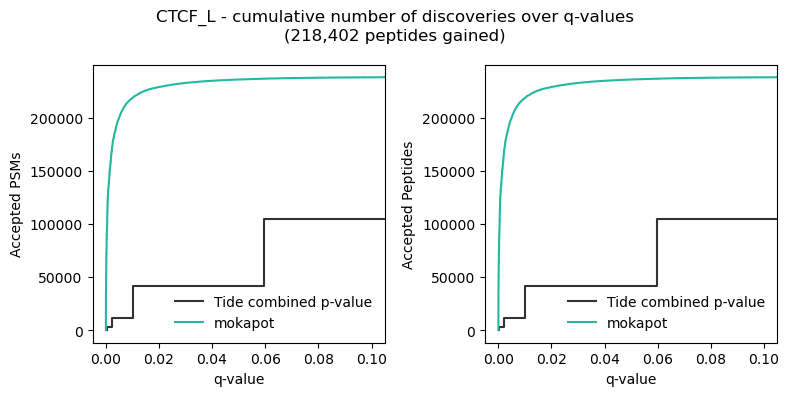

In [242]:
# plot test data
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
colors = ("#343131", "#24B8A0")

# Plot the performance:
for ax, level in zip(axs, tide_conf.levels):
    tide_conf.plot_qvalues(level=level, c=colors[0], ax=ax,
                           label="Tide combined p-value")
    moka_conf.plot_qvalues(level=level, c=colors[1], ax=ax,
                           label="mokapot")
    ax.legend(frameon=False)

fig.suptitle("{} - cumulative number of discoveries over q-values\n({:,} peptides gained)".format(title, moka_peps))

plt.tight_layout()

# save fig
plt.savefig("{}/{}_mokapot_performance.pdf".format(data_dir, title))

plt.show()

In [226]:
moka_conf

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.05: 235825
	- Peptides at q<=0.05: 235825

In [229]:
# save output
output_dir = data_dir
file_root = "CTCF_L"
result_files = moka_conf.to_txt(dest_dir=output_dir, file_root=file_root)
result_files

['/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_L.mokapot.psms.txt',
 '/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_L.mokapot.peptides.txt']

## looking at res

In [283]:
# CTCF L (best footprint according to Andrew)
data_type = "positive"
motif_type = "L"
data_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.txt".format(data_dir, data_type, motif_type)

In [284]:
os.path.basename(data_file)

'CTCF_positive_m6a_fiberseq_L_100bp_features.txt'

In [288]:
"{}/CTCF_merged_100bp_features_{}.pin".format(data_dir, "_".join(filter(None, (motif_type, data_type))))

'/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_merged_100bp_featuresL_positive.pin'

In [ ]:
"{}/CTCF_merged_100bp_features_{}.pin".format(data_dir, "_".join(filter(None, (motif_type, data_type))))

In [286]:
'_'.join(filter(None, (motif_type, data_type)))

'L_positive'

In [275]:
moka_conf

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.05: 235825
	- Peptides at q<=0.05: 235825

In [256]:
models

(A trained mokapot.model.Model object:
 	estimator: XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='auc', feature_types=None, gamma=1, gpu_id=-1,
               grow_policy='depthwise', importance_type=None,
               interaction_constraints='', learning_rate=0.300000012,
               max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
               max_delta_step=0, max_depth=9, max_leaves=0, min_child_weight=3,
               missing=nan, monotone_constraints='()', n_estimators=100,
               n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)
 	scaler: StandardScaler()
 	features: ['msp_size', 'left_m6a_count', 'right_m6a_count', 'motif_m6a_count', 'left_AT_count', 'right_AT_count', 'motif_AT_count', 'left_AT_prop', 'right_AT_prop', 'motif_AT_prop', 'left_m6a_pro

In [264]:
train.Label.value_counts()

 1    238348
-1     65943
Name: Label, dtype: int64

In [265]:
moka_conf.psms.head()

,SpecID,Label,Peptide,scannr,mokapot score,mokapot q-value,mokapot PEP,Proteins
0,26783,True,26783,26783,1.0,0.000032,0.001743,26783
1,127956,True,127956,127956,1.0,0.000032,0.001743,127956
2,127916,True,127916,127916,1.0,0.000032,0.001743,127916
3,127949,True,127949,127949,1.0,0.000032,0.001743,127949
4,204541,True,204541,204541,1.0,0.000032,0.001743,204541


# merge with ft center data


1. add mokapot q-value column to ft center table
2. map SpecID in pin back to individual pin files (pos, neg)
3. get motif_name and query_name from feature txt table
4. load ft center output table
5. concat mokapot q-value to ft center table using motif_name and query_name

### CTCF_L_small_negative

In [7]:
# input feature files
motif_type = "L"
file_root = motif_type

dataset_type = "positive"
pos_file = "{}/CTCF_m6a_fiberseq_{}_100bp_{}_features-motif_query.txt".format(data_dir, motif_type, dataset_type)
print("Positive file: {}".format(os.path.basename(pos_file)))
df_pos = pd.read_csv(pos_file, sep="\t",)
print("Positive features - rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))
print("\n")

dataset_type = "small_negative"
neg_file = "{}/CTCF_m6a_fiberseq_{}_100bp_{}_features-motif_query.txt".format(data_dir, motif_type, dataset_type)
print("Negative file: {}".format(os.path.basename(neg_file)))
df_neg = pd.read_csv(neg_file, sep="\t",)
print("Negative - rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

Positive file: CTCF_m6a_fiberseq_L_100bp_positive_features-motif_query.txt
Positive features - rows: 238,348 | cols: 129


Negative file: CTCF_m6a_fiberseq_L_100bp_small_negative_features-motif_query.txt
Negative - rows: 65,943 | cols: 129


In [ ]:
# mokapot output file
res_file = "{}/CTCF_{}.mokapot.psms.txt".format(data_dir, file_root)

In [266]:
print(pin_file)

/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_m6a_fiberseq_L_100bp_features.pin


In [268]:
train.head()

,SpecID,Label,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop,Peptide,Proteins,scannr
0,0,1,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,0,0,0
1,1,1,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,1,1,1
2,2,1,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,2,2,2
3,3,1,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667,3,3,3
4,4,1,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333,4,4,4


In [269]:
# read in positive feature data

data_type = "positive"
motif_type = "L"
data_file = "{}/CTCF_{}_m6a_fiberseq_{}_100bp_features.txt".format(data_dir, data_type, motif_type)

In [270]:
%%time

# read in feature df
n_rows = None
df_pos = pd.read_csv(data_file, sep="\t", nrows=n_rows)
print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

rows: 238,348 | cols: 128
CPU times: user 1.51 s, sys: 92.6 ms, total: 1.6 s
Wall time: 1.61 s


In [271]:
df_pos.head()

,motif_name,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,left_AT_prop,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
0,chr10_100338605_+,m54329U_210323_190418/12585455/ccs,200.0,13.0,13.0,3.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333
1,chr10_100338605_+,m54329U_210323_190418/16515087/ccs,212.0,12.0,12.0,4.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
2,chr10_100338605_+,m54329U_210323_190418/169477611/ccs,181.0,10.0,12.0,2.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000
3,chr10_100338605_+,m54329U_210323_190418/173999297/ccs,134.0,9.0,11.0,8.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
4,chr10_100338605_+,m54329U_210323_190418/180160021/ccs,194.0,12.0,12.0,1.0,18.0,18.0,13.0,0.45,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333


In [272]:
d_pos = df_pos.copy(deep=True)

# add Label col of 0's
d_pos.insert(1, "Label", 0)

# make Label value 1 for positive data
d_pos["Label"] = d_pos["Label"].replace(0, 1)
print("rows: {:,} | cols: {:,}".format(d_pos.shape[0], d_pos.shape[1]))

rows: 238,348 | cols: 129


In [274]:
d_pos.head()

,motif_name,Label,query_name,msp_size,left_m6a_count,right_m6a_count,motif_m6a_count,left_AT_count,right_AT_count,motif_AT_count,...,TGT_count,TGT_m6a_prop,TTA_count,TTA_m6a_prop,TTC_count,TTC_m6a_prop,TTG_count,TTG_m6a_prop,TTT_count,TTT_m6a_prop
0,chr10_100338605_+,1,m54329U_210323_190418/12585455/ccs,200.0,13.0,13.0,3.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333
1,chr10_100338605_+,1,m54329U_210323_190418/16515087/ccs,212.0,12.0,12.0,4.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
2,chr10_100338605_+,1,m54329U_210323_190418/169477611/ccs,181.0,10.0,12.0,2.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000
3,chr10_100338605_+,1,m54329U_210323_190418/173999297/ccs,134.0,9.0,11.0,8.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.333333,0.0,0.0,0.0,0.0,1.0,0.666667
4,chr10_100338605_+,1,m54329U_210323_190418/180160021/ccs,194.0,12.0,12.0,1.0,18.0,18.0,13.0,...,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333


In [277]:
# confidence estimates based on the best original feature
tide_conf = train_psms.assign_confidence()

In [279]:
tide_conf

A mokapot.confidence.LinearConfidence object:
	- PSMs at q<=0.01: 11596
	- Peptides at q<=0.01: 11596

In [280]:
tide_conf.levels

['psms', 'peptides', 'proteins']

### CTCF_100bp_small_5_L 

* mokapot res: CTCF_100bp_small_5_L.mokapot.psms.txt
* pin file: CTCF_m6a_fiberseq_merged_100bp_features-small_L_5.pin
* feature files
    * CTCF_m6a_fiberseq_L_100bp_small_5_negative_features.txt
    * pos: CTCF_m6a_fiberseq_merged_100bp_positive_features.pin
    * neg: CTCF_m6a_fiberseq_L_100bp_small_5_negative_features.pin
* fiberseq files:
    * pos: CTCF_m6a_fiberseq_merged_100bp_positive.txt
    * neg: CTCF_m6a_fiberseq_L_100bp_small_5_negative.txt
    
<br><font color="red">__accidentally used MERGED positive data__</font>

In [43]:
# set folders
project_dir = "/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting"
data_dir = "{}/feature_data".format(project_dir)
fiber_dir = "{}/candidate_footprints".format(project_dir)
moka_dir = "{}/mokapot_res".format(project_dir)

#### format fiberseq data (pos)

In [45]:
# positive fiberseq reads
pos_file = "{}/CTCF_m6a_fiberseq_merged_100bp_positive.txt".format(fiber_dir)
assert os.path.exists(pos_file), f"ERROR: file not found: {pos_file}"

# read feature file
df_pos = pd.read_csv(pos_file, sep="\t")
print("Pos features - rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

Pos features - rows: 43,760,947 | cols: 13


In [46]:
# filter for only m6a & msp rows
df_pos = df_pos[df_pos["centered_position_type"].isin(["m6a", "msp"])]
print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

# make column of motif_name & motif_query names
df_pos.insert(loc=0, column="motif_name", value=
              df_pos["chrom"]+"_"+df_pos["centering_position"].astype(str)+"_"+df_pos["strand"].astype(str))
df_pos.insert(loc=0, column="motif_query", value=
              df_pos["motif_name"].astype(str)+"/"+df_pos["query_name"].astype(str))

print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

rows: 40,559,087 | cols: 13
rows: 40,559,087 | cols: 15


In [47]:
print("Columns: {:,}".format(df_pos.shape[1]))
print("Total rows: " + "{:,}".format(df_pos.shape[0]))
print("Total unique motifs: {:,}".format(df_pos.motif_name.nunique()))
print("Total unique query_names: " + "{:,}".format(df_pos.query_name.nunique()))

print("MSP's: " + "{:,}".format(df_pos[df_pos["centered_position_type"] == "msp"].shape[0]))
print("m6a's: " + "{:,}".format(df_pos[df_pos["centered_position_type"] == "m6a"].shape[0]))

Columns: 15
Total rows: 40,559,087
Total unique motifs: 22,609
Total unique query_names: 911,360
MSP's: 1,374,687
m6a's: 39,184,400


In [48]:
def clean_sequences(df):
    '''Remove rows with N characters.'''
    print("Removing "+ "{:,} rows.".format(df["subset_sequence"].str.contains("N").sum()))
    return df[~df["subset_sequence"].str.contains("N")]

In [49]:
# remove rows with Ns in sequence
df_pos = clean_sequences(df_pos)

Removing 387,512 rows.


In [50]:
def filt_msps(df, motif_len=35):
    '''Filters for motif/query instances with a motif within 
    a MSP and adds MSP length to each motif/query group.'''
    
    # position of MSPs containing a motif
    msp_mask = (df["centered_position_type"] == "msp") & (df["centered_start"] <= 0) & (df["centered_end"] >= motif_len)
    print("MSP's with a motif: " + "{:,}".format(msp_mask.sum()))
    msp_groups = [(row["motif_name"], row["query_name"]) for idx, row in df[msp_mask].iterrows()]
    
    # filter for rows with motifs within an MSP (gets both MSP's & m6a's)
    df = df[df[["motif_name", "query_name"]].apply(tuple, 1).isin(msp_groups)]
    print("Total observations from motifs within an MSP: " + "{:,}".format(df.shape[0]))
    
    # add MSP size corresponding to each group
    # df with msp sizes
    df_msp = df.loc[msp_mask, ["motif_name", "query_name", "centered_end", "centered_start"]]
    df_msp["msp_size"] = df_msp["centered_end"] - df_msp["centered_start"]

    # match msp back to it's motif & fiber
    df = df.merge(df_msp[["motif_name", "query_name", "msp_size"]], on=["motif_name", "query_name"])
    print("Merged df shape w/ msp_size: " + "{:,}".format(df.shape[0]))
    return df

In [51]:
# filter for regions with a motif within an MSP & add MSP size col
df_pos = filt_msps(df_pos)
# remove MSP rows
df_pos = df_pos[df_pos["centered_position_type"] == "m6a"]
print("Total m6a observations: " + "{:,}".format(df_pos.shape[0]))

MSP's with a motif: 814,278
Total observations from motifs within an MSP: 33,101,000
Merged df shape w/ msp_size: 33,101,265
Total m6a observations: 32,281,947


In [59]:
df_pos.head()

,motif_query,motif_name,chrom,centering_position,strand,subset_sequence,reference_start,reference_end,query_name,centered_query_start,centered_query_end,query_length,centered_position_type,centered_start,centered_end,msp_size
0,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-91,-90,500
1,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-81,-80,500
2,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-76,-75,500
3,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-73,-72,500
4,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-64,-63,500


In [52]:
# group by motif & query name
grouping_cols = ["motif_name", "query_name"]
df_grouped = df_pos.groupby(grouping_cols)

# get group names (keys)
group_names = list(df_grouped.groups.keys())
print("Unique motif-sequence groups: " + "{:,}".format(len(group_names)))

Unique motif-sequence groups: 814,275


#### format fiberseq data (neg)

In [53]:
# negative fiberseq reads
neg_file = "{}/CTCF_m6a_fiberseq_L_100bp_small_5_negative.txt".format(fiber_dir)
assert os.path.exists(neg_file), f"ERROR: file not found: {neg_file}"

# read feature file
df_neg = pd.read_csv(neg_file, sep="\t")
print("Neg features - rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

Neg features - rows: 39,485,334 | cols: 13


In [54]:
# filter for only m6a & msp rows
df_neg = df_neg[df_neg["centered_position_type"].isin(["m6a", "msp"])]
print("rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))

# make column of motif_name & motif_query names
df_neg.insert(loc=0, column="motif_name", value=
              df_neg["chrom"]+"_"+df_neg["centering_position"].astype(str)+"_"+df_neg["strand"].astype(str))
df_neg.insert(loc=0, column="motif_query", value=
              df_neg["motif_name"].astype(str)+"/"+df_neg["query_name"].astype(str))

print("rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

rows: 32,281,947 | cols: 16
rows: 32,102,125 | cols: 15


In [55]:
print("Columns: {:,}".format(df_neg.shape[1]))
print("Total rows: " + "{:,}".format(df_neg.shape[0]))
print("Total unique motifs: {:,}".format(df_neg.motif_name.nunique()))
print("Total unique query_names: " + "{:,}".format(df_neg.query_name.nunique()))
print("unique motif/query groups: {:,}".format(df_neg["motif_query"].nunique()))

print("MSP's: " + "{:,}".format(df_neg[df_neg["centered_position_type"] == "msp"].shape[0]))
print("m6a's: " + "{:,}".format(df_neg[df_neg["centered_position_type"] == "m6a"].shape[0]))

Columns: 15
Total rows: 32,102,125
Total unique motifs: 702,809
Total unique query_names: 430,490
unique motif/query groups: 2,112,659
MSP's: 2,717,416
m6a's: 29,384,709


In [56]:
# remove rows with Ns in sequence
df_neg = clean_sequences(df_neg)

Removing 216,546 rows.


In [60]:
# filter for regions with a motif within an MSP & add MSP size col
df_neg = filt_msps(df_neg)

# remove MSP rows
df_neg = df_neg[df_neg["centered_position_type"] == "m6a"]
print("Total m6a observations: " + "{:,}".format(df_neg.shape[0]))

MSP's with a motif: 331,589
Total observations from motifs within an MSP: 8,380,444
Merged df shape w/ msp_size: 8,383,268
Total m6a observations: 8,040,195


In [61]:
# group by motif & query name
grouping_cols = ["motif_name", "query_name"]
df_grouped = df_neg.groupby(grouping_cols)

# get group names (keys)
group_names = list(df_grouped.groups.keys())
print("Unique motif-sequence groups: " + "{:,}".format(len(group_names)))

Unique motif-sequence groups: 331,543


#### merge formated fiberseq data w/ mokapot

In [39]:
# mokapot output file
res_file = "{}/CTCF_100bp_small_5_L.mokapot.psms.txt".format(output_dir)
print("Mokapot res file: {}".format(os.path.basename(res_file)))

Mokapot res file: CTCF_100bp_small_5_L.mokapot.psms.txt


In [41]:
# read res
res = pd.read_csv(res_file, sep="\t")
print("Mokapot res - rows: {:,} | cols: {:,}".format(res.shape[0], res.shape[1]))

Mokapot res - rows: 814,274 | cols: 8


In [42]:
res.head()

,SpecID,Label,Peptide,scannr,mokapot score,mokapot q-value,mokapot PEP,Proteins
0,chr6_153024626_-/m64076_221119_202646/57934276...,True,654362,654362,0.999871,0.000288,0.002141,654362
1,chr6_153024626_-/m54329U_210814_130637/6488291...,True,654339,654339,0.999840,0.000288,0.002144,654339
2,chr6_153024626_-/m54329U_210813_020940/1526348...,True,654330,654330,0.999826,0.000288,0.002145,654330
3,chr5_150436278_-/m64076_210328_012155/30673226...,True,613169,613169,0.999821,0.000288,0.002145,613169
4,chr6_153024626_-/m64076_221119_202646/59049992...,True,654363,654363,0.999808,0.000288,0.002146,654363


In [62]:
print("res rows: {:,} | cols: {:,}".format(res.shape[0], res.shape[1]))
print("pos rows: {:,} | cols: {:,}".format(df_pos.shape[0], df_pos.shape[1]))
print("neg rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

res rows: 814,274 | cols: 8
pos rows: 32,281,947 | cols: 16
neg rows: 8,040,195 | cols: 16


In [63]:
# rename mokapot q-value column to FDR & SpecID to motif_query
res = res.rename(columns={"mokapot q-value": "FDR", "SpecID": "motif_query"})

In [67]:
res.head(1)

,motif_query,Label,Peptide,scannr,mokapot score,FDR,mokapot PEP,Proteins
0,chr6_153024626_-/m64076_221119_202646/57934276...,True,654362,654362,0.999871,0.000288,0.002141,654362


In [68]:
# add mokapot q-value to POS table
d = pd.merge(df_pos, res[["motif_query", "Label", "FDR"]], on="motif_query", how="inner")
print("rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))

rows: 32,281,919 | cols: 18


In [72]:
# save merged POS table
output_file = res_file.replace("psms.txt", "m6a_fiberseq-positive.txt")
d.to_csv(output_file, sep="\t", header=True, index=False)
print("Saving to: {}".format(os.path.basename(output_file)))

Saving to: CTCF_100bp_small_5_L.mokapot.m6a_fiberseq-positive.txt


In [77]:
d.head()

,motif_query,motif_name,chrom,centering_position,strand,subset_sequence,reference_start,reference_end,query_name,centered_query_start,centered_query_end,query_length,centered_position_type,centered_start,centered_end,msp_size,Label,FDR
0,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-91,-90,500,True,0.023952
1,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-81,-80,500,True,0.023952
2,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-76,-75,500,True,0.023952
3,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-73,-72,500,True,0.023952
4,chr1_778834_-/m54329U_210323_190418/57542526/ccs,chr1_778834_-,chr1,778834,-,CCGGCGCCGAAGACCGGGAAGTCGTAAAGCTCCTCCTCGTGGCTTA...,755085,783504,m54329U_210323_190418/57542526/ccs,-23863,4695,28558,m6a,-64,-63,500,True,0.023952


In [78]:
# add Label & mokapot q-value to NEG table
df_neg["Label"] = False
df_neg["FDR"] = 1

print("rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

rows: 0 | cols: 18


In [81]:
print("rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

rows: 8,040,195 | cols: 18


In [82]:
# save merged NEG table
output_file = res_file.replace("psms.txt", "m6a_fiberseq-negative.txt")
df_neg.to_csv(output_file, sep="\t", header=True, index=False)
print("Saving to: {}".format(os.path.basename(output_file)))

Saving to: CTCF_100bp_small_5_L.mokapot.m6a_fiberseq-negative.txt


#### merge POS & NEG data

In [83]:
print("pos rows: {:,} | cols: {:,}".format(d.shape[0], d.shape[1]))
print("neg rows: {:,} | cols: {:,}".format(df_neg.shape[0], df_neg.shape[1]))

pos rows: 32,281,919 | cols: 18
neg rows: 8,040,195 | cols: 18


In [84]:
# merge negative features with positive features (append rows)
d_merged = pd.concat([d, df_neg])
print("rows: {:,} | cols: {:,}".format(d_merged.shape[0], d_merged.shape[1]))

rows: 40,322,114 | cols: 18


In [86]:
# save merged table
output_file = res_file.replace("psms.txt", "m6a_fiberseq.txt")
d_merged.to_csv(output_file, sep="\t", header=True, index=False)
print("Saving to: {}".format(os.path.basename(output_file)))

Saving to: CTCF_100bp_small_5_L.mokapot.m6a_fiberseq.txt


## make performance figures

In [87]:
# set folders
project_dir = "/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting"
data_dir = "{}/feature_data".format(project_dir)
fiber_dir = "{}/candidate_footprints".format(project_dir)
moka_dir = "{}/mokapot_res".format(project_dir)

### CTCF_L small negative

In [89]:
pin_file = "{}/CTCF_m6a_fiberseq_L_100bp_features.pin".format(data_dir)
assert os.path.exists(neg_file), f"ERROR: file not found: {pin_file}"

In [90]:
# read pin
pin = pd.read_csv(pin_file, sep="\t")
print("Pin features - rows: {:,} | cols: {:,}".format(pin.shape[0], pin.shape[1]))

Pin features - rows: 304,291 | cols: 131


In [99]:
train = pin

In [100]:
train_psms = mokapot.read_pin(pin)

In [101]:
tide_conf = train_psms.assign_confidence(eval_fdr=0.05)

In [102]:
# how to weigh pos vs neg labels based on frequency
scale_pos_weight = sum(train.Label == -1) / sum(train.Label == 1)

# common hyper parameters for XGBoost
grid = {
    # how many decision trees to use in the model
    "n_estimators": [25, 50, 100],
    # weighing for imbalanced data
    "scale_pos_weight": [scale_pos_weight],
    # depth of tree
    "max_depth": [3, 6, 9],
    # number of rows a terminal leaf needs to touch
    "min_child_weight": [3, 6, 9],
    # learning rate
    "gamma": [0.1, 1, 10],
}

# setting up the model (ensemble classifier)
xgb_mod = GridSearchCV(
    XGBClassifier( eval_metric = "auc"),#use_label_encoder = False, eval_metric = "auc"),
    param_grid = grid,
    cv = 3,
    # receiver operator curve
    scoring = "roc_auc",
    verbose = 2,
)

In [103]:
# use only a random subset of the PSMs for training (only use for large datasets, must be <= # features)
subset_max_train = None
# machine learning model to re-score PSMs
mod = mokapot.Model(xgb_mod, train_fdr = 0.1, subset_max_train = subset_max_train)

In [104]:
%%time
# run mokapot
moka_conf, models = mokapot.brew(train_psms, mod, test_fdr = 0.05)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.8s
[CV] END gamma=0.1, max_depth=3, min_child_weigh

[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   8.0s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   7.9s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; 

[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.6s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.2s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.3s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.4s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.4s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.

[CV] END gamma=10, max_depth=6, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.2s
[CV] END gamma=10, max_depth=6, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.3s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.8s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.8s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.8s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; t

[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.8s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=1, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.

[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.3s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   8.0s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   8.2s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   8.2s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.4s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.

[CV] END gamma=10, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.3s
[CV] END gamma=10, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.3s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.5s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.8s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   3.0s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   2.8s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   5.3s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; t

[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=1, max_depth=6, min_child_weight=3, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.

[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   1.6s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   2.9s
[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   3.0s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   1.0s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   0.9s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=50, scale_pos_weight=0.27666689042912046; total ti

[CV] END gamma=10, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   7.9s
[CV] END gamma=10, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=0.27666689042912046; total time=   8.4s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.6s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=0.27666689042912046; total time=   2.3s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.1s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total time=   4.3s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=0.27666689042912046; total tim

# running mokapot on rle

In [106]:
# merged data
n_rows = None
pin_file = "{}/CTCF_m6a_fiberseq_L_100bp_features-small_L_5_rle.pin".format(data_dir)
assert os.path.exists(neg_file), f"ERROR: file not found: {neg_file}"

# read pin
pin = pd.read_csv(pin_file, sep="\t")
print("Pin features - rows: {:,} | cols: {:,}".format(pin.shape[0], pin.shape[1]))

Pin features - rows: 569,888 | cols: 22


In [124]:
res_file.replace("psms", "m6a_fiberseq")

'/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/mokapot_res/CTCF_100bp_small_5_L.mokapot.m6a_fiberseq.txt'

In [112]:
pin.Label.value_counts()

-1    331540
 1    238348
Name: Label, dtype: int64

In [108]:
train = pin
train_psms = mokapot.read_pin(pin)

In [113]:
train_fdr = 0.5
test_fdr = 0.05

tide_conf = train_psms.assign_confidence(eval_fdr=train_fdr)

In [114]:
# how to weigh pos vs neg labels based on frequency
scale_pos_weight = sum(train.Label == -1) / sum(train.Label == 1)

# common hyper parameters for XGBoost
grid = {
    # how many decision trees to use in the model
    "n_estimators": [25, 50, 100],
    # weighing for imbalanced data
    "scale_pos_weight": [scale_pos_weight],
    # depth of tree
    "max_depth": [3, 6, 9],
    # number of rows a terminal leaf needs to touch
    "min_child_weight": [3, 6, 9],
    # learning rate
    "gamma": [0.1, 1, 10],
}

# setting up the model (ensemble classifier)
xgb_mod = GridSearchCV(
    XGBClassifier( eval_metric = "auc"),#use_label_encoder = False, eval_metric = "auc"),
    param_grid = grid,
    cv = 3,
    # receiver operator curve
    scoring = "roc_auc",
    verbose = 2,
)

In [115]:
# use only a random subset of the PSMs for training (only use for large datasets, must be <= # features)
subset_max_train = None
# machine learning model to re-score PSMs
mod = mokapot.Model(xgb_mod, train_fdr = train_fdr, subset_max_train = subset_max_train)

In [116]:
%%time
# run mokapot
moka_conf, models = mokapot.brew(train_psms, mod, test_fdr = test_fdr)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.3s
[CV] END gamma=0.1, max_depth=3, min_child_weight=3, n_

[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.2s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.1s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   4.0s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   4.0s
[CV] END gamma=0.1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   4.0s
[CV] END gamma=0.1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=1.3909913236108546; total ti

[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   2.7s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=  12.4s
[CV] END gamma=1, max_depth=6, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=  26.0s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   9.4s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   6.5s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.3s
[CV] END gamma=1, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.2s
[CV] 

[CV] END gamma=10, max_depth=6, min_child_weight=3, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   2.5s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   1.6s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   1.6s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   1.6s
[CV] END gamma=10, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   2.9

[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.3s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] END gamma=0.1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total ti

[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] END gamma=1, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] END gamma=1, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=1, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] 

[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   4.0s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   4.0s
[CV] END gamma=1, max_depth=9, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   4.0s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.2s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.2s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.2s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.1s
[CV] END gamma=1, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.1s
[CV] 

[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.2s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.1s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.1s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.1s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   3.6s
[CV] END gamma=10, max_depth=9, min_child_weight=3, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   3.8

[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   2.6s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   2.6s
[CV] END gamma=0.1, max_depth=6, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   2.6s
[CV] END gamma=0.1, max_depth=6, min_child_weight=9, n_estimators=25, scale_pos_weight=1.3909913236108546; total ti

[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.3s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.3s
[CV] END gamma=1, max_depth=3, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.3s
[CV] END gamma=1, max_depth=6, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=1, max_depth=6, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=1, max_depth=6, min_child_weight=3, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.8s
[CV] END gamma=1, max_depth=6, min_child_weight=3, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   1.4s
[CV] 

[CV] END gamma=10, max_depth=3, min_child_weight=3, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.3s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   0.4s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   0.7s
[CV] END gamma=10, max_depth=3, min_child_weight=6, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   1.3

[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=25, scale_pos_weight=1.3909913236108546; total time=   1.2s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.0s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.1s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=50, scale_pos_weight=1.3909913236108546; total time=   2.1s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   3.7s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   3.6s
[CV] END gamma=10, max_depth=9, min_child_weight=9, n_estimators=100, scale_pos_weight=1.3909913236108546; total time=   3.8s


RuntimeError: No PSMs found below the 'eval_fdr'.

In [117]:
# save output
output_dir = data_dir
file_root = "CTCF_small_L_5_rle"
result_files = moka_conf.to_txt(dest_dir=output_dir, file_root=file_root)
result_files

['/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_small_L_5_rle.mokapot.psms.txt',
 '/mmfs1/gscratch/stergachislab/mwperez/ctcf-footprinting/feature_data/CTCF_small_L_5_rle.mokapot.peptides.txt']

In [120]:
train_fdr = 0.1
test_fdr = 0.05

tide_conf = train_psms.assign_confidence(eval_fdr=train_fdr)

RuntimeError: No PSMs found below the 'eval_fdr'.

TypeError: 'NoneType' object is not subscriptable

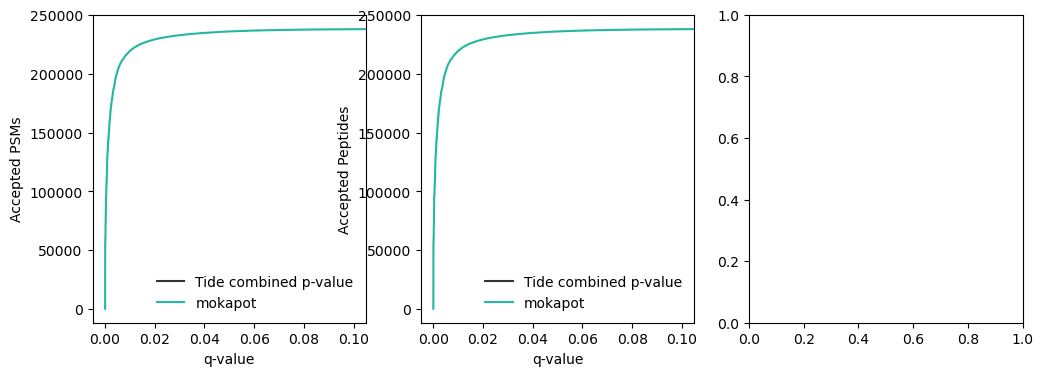

In [118]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
colors = ("#343131", "#24B8A0")

# Plot the performance:
for ax, level in zip(axs, tide_conf.levels):
    tide_conf.plot_qvalues(level=level, c=colors[0], ax=ax,
                           label="Tide combined p-value")
    moka_conf.plot_qvalues(level=level, c=colors[1], ax=ax,
                           label="mokapot")
    ax.legend(frameon=False)

plt.tight_layout()
plt.show()